In [83]:
import matplotlib.animation as animation

from brian2 import *


### global parameters
N = 100
defaultclock.dt = 1*ms


### simulation code
def run_sim(K, F, Delta, p1, p2, omega_0, tau, sigma, random_seed=214040893):
    seed(random_seed)

    eqs = '''
    dTheta/dt = omega + K/N*coupling + F*sin(sigma*t - Theta + p): 1
    omega : Hz (constant) # intrinsic frequency
    coupling : 1
    p : 1
    '''

    oscillators = NeuronGroup(N, eqs, method='euler')
    oscillators.Theta = 'rand()*2*pi'  # random initial phase
    oscillators.p = p1


    #CHANGE THIS TO ANOTHER VALUE
    lorentzian_omegas = omega_0 + Delta * np.tan(np.pi * (np.random.rand(N) - 0.5))
    oscillators.omega = lorentzian_omegas
    #oscillators.Theta = p1


    connections = Synapses(oscillators, oscillators,
                        'coupling_post = sin(Theta_pre - Theta_post) : 1 (summed)')
    connections.connect()  # all-to-all

    mon = StateMonitor(oscillators, 'Theta', record=True)

   # Variable to hold the current value of z
    z_values = []

    @network_operation()
    def update_p() :
        if defaultclock.t <= tau :
            oscillators.p = p1
        else :
            oscillators.p = p2
    
    @network_operation()
    def compute_z():
        # Calculate z(t) using the current phases
        z = np.mean(np.exp(1j * (oscillators.Theta[:] - (sigma * defaultclock.t) - p2)))
        z_values.append(z)

    net = Network(oscillators, connections, mon, compute_z, update_p)
    net.run(10*second)

    return z_values
        

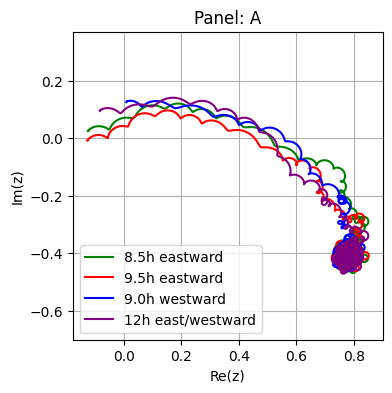

In [85]:
# Example parameters
Delta = 1 * Hz  # Width of the Lorentzian distribution
K = 4.5 * Delta      # Coupling strength
F = 3.5 * Delta # Amplitude of external driving force
sigma = 2*pi/(24*3600)*Hz
Omega = 1.4 * Delta
omega_0 = sigma - Omega
initial_p2 = [9.5, 8.5, -9, -12]
colors = ['green', 'red', 'blue', 'purple']  # Colors for each travel point
labels = ['8.5h eastward', '9.5h eastward', '9.0h westward', '12h east/westward']

tau = 0*second  # Time of travel
plt.figure(figsize=(4, 4))
for i, p2 in enumerate(initial_p2):
    real_p2 = p2 * (2 * pi) / 24
    z_final = run_sim(K, F, Delta, 0, real_p2, omega_0, tau, sigma)
    z_real = np.real(z_final)
    z_imag = np.imag(z_final)
    plt.plot(z_real, z_imag, label=labels[i], color=colors[i])
# Labels and formatting
plt.xlabel("Re(z)")
plt.ylabel("Im(z)")
plt.title(f"Panel: A")
plt.legend()
plt.axis("equal")
plt.grid()
plt.show()

